# Fine-tuning ESM2 on promiscuous esterases

In [4]:
# Import dependencies
import torch
from transformers import AutoTokenizer, EsmForMaskedLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from transformers import set_seed
from datasets import Dataset
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import os

In [6]:
# Load  data
df = pd.read_pickle('/nvme2/helen/masterthesis/manuscript/trainingdata/promiscuous_esterases_train_test_0p5_similarity_splits.pkl')
df = df.head(1000)
df_train = df[df['split'] == 'train'].reset_index(drop=True)
df_test = df[df['split'] == 'test'].reset_index(drop=True)

# Model checkpoint
checkpoint = 'facebook/esm2_t6_8M_UR50D'
output_dir="./finetuning"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [7]:
# Set random seeds for reproducibility of trainings run
def set_seeds(s):
    torch.manual_seed(s)
    np.random.seed(s)
    random.seed(s)
    set_seed(s)


# Dataset creation
def create_dataset(tokenizer,seqs):
    tokenized = tokenizer(seqs, max_length=1024, padding=True, truncation=True)
    dataset = Dataset.from_dict(tokenized)

    return dataset


# Load ESM2 model
def load_esm_model(checkpoint, unfrozen_layers, deepspeed=False):

    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    model = EsmForMaskedLM.from_pretrained(checkpoint)
    
    #peft_config = LoraConfig(
    #    r=4, lora_alpha=1, bias="all", target_modules=["query","key","value","dense"]
    #)
    
    #model = inject_adapter_in_model(peft_config, model)
    
    # Freeze and unfreeze correct layers
    num_encoder_layers = model.esm.encoder.config.num_hidden_layers # Number of layers in the model
    num_unfrozen_layers = unfrozen_layers # Train the last x layers

    for i, layer in enumerate(model.esm.encoder.layer):
        if i < num_encoder_layers - num_unfrozen_layers:
            for param in layer.parameters():
                param.requires_grad = False
        else:
            print(f"Layer {i} (0-indexed) will be trained.")

    # Also ensure lm_head is trainable (it should be by default)
    for param in model.lm_head.parameters():
        param.requires_grad = True
    print("LM Head will be trained.")

    # Verify which parameters are trainable
    print("\nTrainable parameters:")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name)
       
    return model, tokenizer


# Main training fuction
def train_per_protein(
        checkpoint,       #model checkpoint
        output_dir,       #output directory

        train_df,         #training data
        #valid_df,         #validation data      

        # effective training batch size is batch * accum
        # we recommend an effective batch size of 8 
        batch = 4,        #for training
        accum = 2,        #gradient accumulation

        val_batch = 16,   #batch size for evaluation
        epochs = 10,      #training epochs
        lr = 3e-4,        # learning rate
        seed = 42,        #random seed
        deepspeed = False,#if gpu is large enough disable deepspeed for training speedup
        mixed = True,     #enable mixed precision training
        full = False,     #enable training of the full model (instead of LoRA)
        gpu = 1 ):        #gpu selection (1 for first gpu)
    
    print("Model used:", checkpoint, "\n")

    # Set random seeds
    set_seeds(seed)

    # Load model
    model, tokenizer = load_esm_model(checkpoint, unfrozen_layers=2)

    # Preprocess inputs: Replace uncommon AAs with "X"
    train_df["sequence"]=train_df["sequence"].str.replace('|'.join(["O","B","U","Z","J"]),"X",regex=True)
    #valid_df["sequence"]=valid_df["sequence"].str.replace('|'.join(["O","B","U","Z","J"]),"X",regex=True)
    
    # Create Datasets
    train_set=create_dataset(tokenizer,list(train_df['sequence']))
    #valid_set=create_dataset(tokenizer,list(valid_df['sequence']),list(valid_df['label']))


    # Define Hugginface Training Arguments
    training_args = TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=True,
        num_train_epochs=5, # Adjust based on dataset size and convergence
        per_device_train_batch_size=8, # Adjust based on your GPU memory
        save_steps=10_000, # Save model every 10,000 steps
        save_total_limit=2, # Keep only the last 2 checkpoints
        prediction_loss_only=True, # For unsupervised training, only loss is relevant
        logging_dir='./logs',
        logging_steps=100,
        report_to="none", # Disable reporting to W&B or other services if not needed
        dataloader_num_workers=2, # Number of subprocesses for data loading
    ) 

    # Data Collator for Masked Language Modeling
    # Dynamically mask tokens in your input sequences during training. `mlm_probability` controls the percentage of tokens to mask.
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=True,
        mlm_probability=0.15 # Standard for MLM
)

    # Create and Train the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_set,
        tokenizer = tokenizer, 
        data_collator=data_collator
    )

    # Train model
    print("\nStarting fine-tuning...")
    trainer.train()
    print(f"Fine-tuning complete! Fine-tuned model and tokenizer saved to {output_dir}")

    return tokenizer, model, trainer.state.log_history



In [8]:
# Run fine-tuning
tokenizer, model, history = train_per_protein(checkpoint, output_dir, df_train, batch = 1, accum = 8, epochs = 20, seed = 42)

Model used: facebook/esm2_t6_8M_UR50D 



Some weights of the model checkpoint at facebook/esm2_t6_8M_UR50D were not used when initializing EsmForMaskedLM: ['esm.embeddings.position_embeddings.weight']
- This IS expected if you are initializing EsmForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Layer 4 (0-indexed) will be trained.
Layer 5 (0-indexed) will be trained.
LM Head will be trained.

Trainable parameters:
esm.embeddings.word_embeddings.weight
esm.encoder.layer.4.attention.self.query.weight
esm.encoder.layer.4.attention.self.query.bias
esm.encoder.layer.4.attention.self.key.weight
esm.encoder.layer.4.attention.self.key.bias
esm.encoder.layer.4.attention.self.value.weight
esm.encoder.layer.4.attention.self.value.bias
esm.encoder.layer.4.attention.output.dense.weight
esm.encoder.layer.4.attention.output.dense.bias
esm.encoder.layer.4.attention.LayerNorm.weight
esm.encoder.layer.4.attention.LayerNorm.bias
esm.encoder.layer.4.intermediate.dense.weight
esm.encoder.layer.4.intermediate.dense.bias
esm.encoder.layer.4.output.dense.weight
esm.encoder.layer.4.output.dense.bias
esm.encoder.layer.4.LayerNorm.weight
esm.encoder.layer.4.LayerNorm.bias
esm.encoder.layer.5.attention.self.query.weight
esm.encoder.layer.5.attention.self.query.bias
esm.encoder.layer.5.attention.self.key

/tmp/ipykernel_4141024/2887227588.py:117: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.



Starting fine-tuning...


/home/helen/miniconda3/envs/promiscuity/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
100,2.341000
200,2.175500


Fine-tuning complete! Fine-tuned model and tokenizer saved to ./finetuning


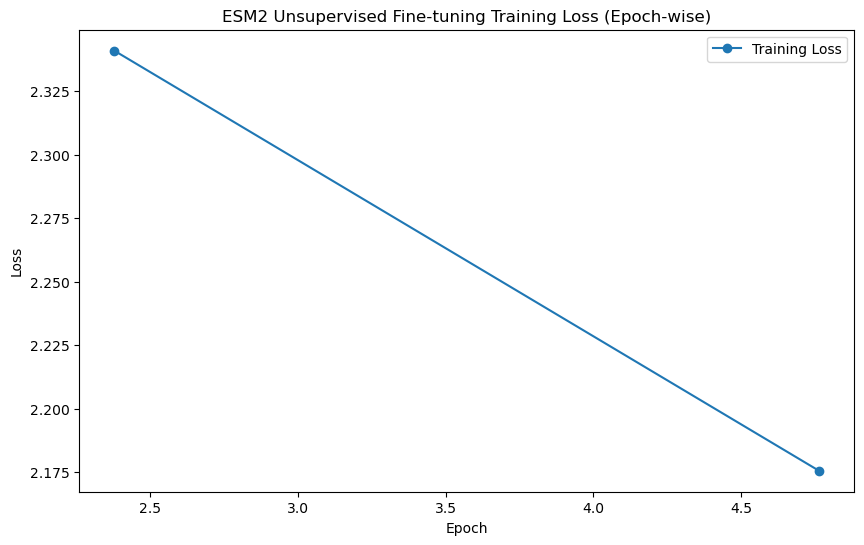

In [13]:
import matplotlib.pyplot as plt

def plot_training_loss(log_history, x_axis='step', output_path=None):
    """
    Plots the training loss from Trainer's log_history.
    
    Args:
        log_history (list): The trainer.state.log_history list of dictionaries.
        x_axis (str): 'step' or 'epoch' — determines x-axis.
        output_path (str, optional): Path to save the plot.
    """
    # Filter for training logs with 'loss' (but not 'eval_loss')
    train_logs = [entry for entry in log_history if 'loss' in entry and 'eval_loss' not in entry]

    if x_axis not in {'step', 'epoch'}:
        raise ValueError("x_axis must be either 'step' or 'epoch'.")

    x_values = [entry.get(x_axis, None) for entry in train_logs]
    y_values = [entry['loss'] for entry in train_logs]

    # Filter out entries where x_axis wasn't recorded
    x_values, y_values = zip(*[(x, y) for x, y in zip(x_values, y_values) if x is not None])

    if not x_values:
        print(f"No valid '{x_axis}' data found in history to plot.")
        return

    plt.figure(figsize=(10, 6))
    plt.plot(x_values, y_values, marker='o', label='Training Loss')
    plt.xlabel('Epoch' if x_axis == 'epoch' else 'Training Step')
    plt.ylabel('Loss')
    plt.title(f"ESM2 Unsupervised Fine-tuning Training Loss ({x_axis.capitalize()}-wise)")
    plt.grid(False)
    plt.legend()

    if output_path:
        #plt.savefig(output_path)
        print(f"Training loss plot saved to {output_path}")
    else:
        plt.show()

plot_training_loss(history, x_axis='epoch')  # or 'step'


In [ ]:
# You can then load and use your fine-tuned model
# from transformers import AutoTokenizer, EsmForMaskedLM
# loaded_tokenizer = AutoTokenizer.from_pretrained("./fine_tuned_esm2_esterase_mlm")
# loaded_model = EsmForMaskedLM.from_pretrained("./fine_tuned_esm2_esterase_mlm")

# Example of using the fine-tuned model for inference (e.g., getting embeddings)
# You would typically load EsmModel for embeddings
# from transformers import EsmModel
# sequence_to_embed = "MKKVLSAIILTVVLACTALAQAAGAAARAAEATGAPGAVGAIGALGGVALAGVLA"
# inputs = loaded_tokenizer(sequence_to_embed, return_tensors="pt", add_special_tokens=True)
# # To get embeddings from EsmForMaskedLM, you need to access its base model
# with torch.no_grad():
#     outputs = loaded_model.esm(**inputs)
# embeddings = outputs.last_hidden_state # Shape: (batch_size, sequence_length, hidden_size)
# # To get sequence-level embedding (e.g., for classification), often the first token (CLS) or mean pooling
# sequence_embedding = embeddings[:, 0, :] # [CLS] token embedding
# print(f"Example embedding shape: {sequence_embedding.shape}")

### After finetuning: How to use the model?

In [ ]:
from transformers import AutoTokenizer, EsmModel # Note: EsmModel, not EsmForMaskedLM
import torch

# Load the fine-tuned model and tokenizer
fine_tuned_model_path = "./fine_tuned_esm2_esterase_mlm"
tokenizer = AutoTokenizer.from_pretrained(fine_tuned_model_path)
model = EsmModel.from_pretrained(fine_tuned_model_path) # Load the base model for embeddings
model.eval() # Set model to evaluation mode

def get_sequence_embedding(sequence, model, tokenizer):
    inputs = tokenizer(sequence, return_tensors="pt", add_special_tokens=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    # The last_hidden_state contains embeddings for all tokens (including CLS and SEP)
    # For a sequence-level embedding, you often use the embedding of the [CLS] token (the first token)
    # or mean pooling over all non-special tokens.
    # [CLS] token embedding:
    sequence_embedding = outputs.last_hidden_state[:, 0, :].squeeze(0) # Remove batch dimension
    return sequence_embedding

# Example usage
new_esterase_sequence = "MKKVLSAIILTVVLACTALAQAAGAAARAAEATGAPGAVGAIGALGGVALAGVLA" # Example sequence
embedding = get_sequence_embedding(new_esterase_sequence, model, tokenizer)
print(f"Embedding for new sequence shape: {embedding.shape}") # Should be (hidden_size,)
print(f"First 5 elements of embedding: {embedding[:5]}")

# You can now use these embeddings for downstream tasks like:
# - Clustering of esterases
# - Training a small classifier (e.g., a simple MLP or SVM) on top of these embeddings
#   for specific tasks like thermostability prediction, substrate specificity, etc.

In [ ]:

# Load ESM2 Tokenizer and Model
model_name = "facebook/esm2_t6_8M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = EsmForMaskedLM.from_pretrained(model_name)

# Prepare dataset
data_dict = {"text": sequences} # Convert sequences into a Hugging Face Dataset
dataset = Dataset.from_dict(data_dict)

# Tokenize the dataset
def tokenize_function(examples):
     return tokenizer(examples["text"], truncation=True, max_length=512) #max_length????????

tokenized_dataset = dataset.map(
    tokenize_function,
    batched=True,
    num_proc=4, # Use multiple processes for faster tokenization
    remove_columns=["text"] 
)

#train_dataset = Dataset.from_dict(train_tokenized)
#test_dataset = Dataset.from_dict(test_tokenized)
#train_dataset = train_dataset.add_column("labels", train_labels)
#test_dataset = test_dataset.add_column("labels", test_labels)

# Freeze layers
num_encoder_layers = model.esm.encoder.config.num_hidden_layers # Number of layers in the model
num_unfrozen_layers = 2 # Train the last 2 layers

for i, layer in enumerate(model.esm.encoder.layer):
    if i < num_encoder_layers - num_unfrozen_layers:
        for param in layer.parameters():
            param.requires_grad = False
    else:
        print(f"Layer {i} (0-indexed) will be trained.")

# Also ensure lm_head is trainable (it should be by default)
for param in model.lm_head.parameters():
    param.requires_grad = True
print("LM Head will be trained.")

# Verify which parameters are trainable
print("\nTrainable parameters:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

In [ ]:

# Data Collator for Masked Language Modeling
# Dynamically mask tokens in your input sequences during training. `mlm_probability` controls the percentage of tokens to mask.
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15 # Standard for MLM
)

output_dir="./finetuning"

# Define Training Arguments
training_args = TrainingArguments(
    output_dir=output_dir,
    overwrite_output_dir=True,
    num_train_epochs=5, # Adjust based on dataset size and convergence
    per_device_train_batch_size=8, # Adjust based on your GPU memory
    save_steps=10_000, # Save model every 10,000 steps
    save_total_limit=2, # Keep only the last 2 checkpoints
    prediction_loss_only=True, # For unsupervised training, only loss is relevant
    logging_dir='./logs',
    logging_steps=100,
    report_to="none", # Disable reporting to W&B or other services if not needed
    dataloader_num_workers=2, # Number of subprocesses for data loading
)


# Create and Train the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    data_collator=data_collator,
)

print("\nStarting fine-tuning...")
trainer.train()
print("Fine-tuning complete!")

# Save the fine-tuned model
model.save_pretrained("./fine_tuned_esm2_esterase_mlm")
tokenizer.save_pretrained("./fine_tuned_esm2_esterase_mlm")

print(f"Fine-tuned model and tokenizer saved to {output_dir}")
